# Test technique

In [178]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [253]:
df = pd.read_csv('data.csv')
df['Experience'] = df['Experience'].str.replace(',', '.').astype('float')
df.head(5)

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.5,Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux


## Question 1

In [180]:
print(f"Le nombre d'observation est de {len(df)}")

Le nombre d'observation est de 9582


Il y a plusieurs valeurs manquantes :

In [181]:
df[df.isna().sum(1) > 0]

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux
28,Voya Financial,Lead data scientist,SAS/Teradata/SQL/R/Python/Machine learning/Ang...,Master,NaN,Marseille
104,Capgemini,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Bachelor,NaN,Bordeaux
161,JLL,Data engineer,C/C++/Java/Python/Linux,Master,NaN,Toulouse
346,Jacobs,NaN,Python/Spark/GNU/Linux,No diploma,2.5,Paris
...,...,...,...,...,...,...
9490,Pearson,NaN,R/Python/Spark/Pycharm/SAS/SQL,Master,4.0,Marseille
9496,United States Soccer Federation,Data scientist,Excel/VBA/R,Master,NaN,Marseille
9498,Delta Air Lines,Data architecte,Java/AWS/Elasticsearch/Kibana,No diploma,NaN,Lyon
9510,General Electric,Data architecte,Hadoop/Hive/Vertica/Tableau,Master,NaN,Toulon


## Question 2

Imputation des valeurs manquantes par la médiane pour les Data scientists, par la moyenne pour les Data engineers

In [254]:
df.loc[(df.Metier == 'Data scientist') & (df.Experience.isna()), 'Experience'] = df.loc[(df.Metier == 'Data scientist') & ~(df.Experience.isna()), 'Experience'].median()
df.loc[(df.Metier == 'Data engineer') & (df.Experience.isna()), 'Experience'] = df.loc[(df.Metier == 'Data engineer') & ~(df.Experience.isna()), 'Experience'].mean()

## Question 3

Expérience en fonction du métier : les lead data scientists sont sans surprise ceux qui ont la plus grande expérience

In [183]:
df.groupby('Metier').agg(mean_exp = ('Experience', 'mean'))

,mean_exp
Metier,
Data architecte,3.000476
Data engineer,2.984959
Data scientist,2.241268
Lead data scientist,3.965261


## Question 4

Visualisation de l'expérience en fonction du métier

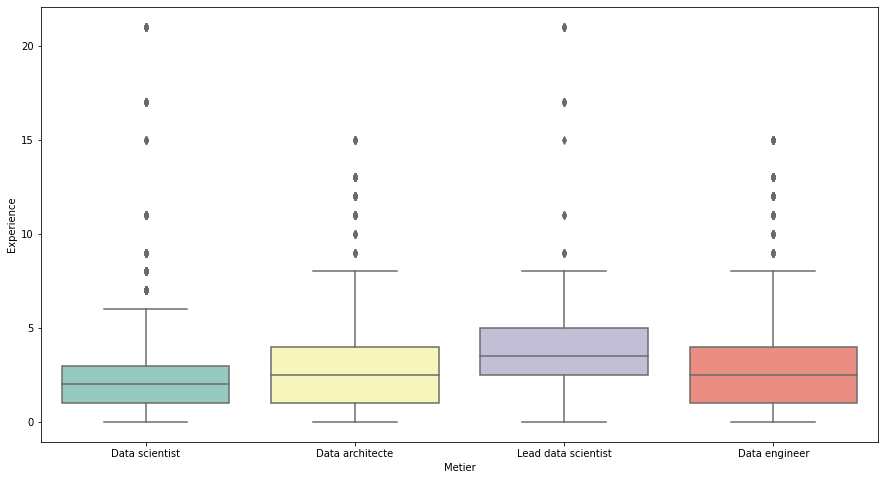

In [184]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Metier", y="Experience",
                 data=df, palette="Set3")

## Question 5

Distribution de l'expérience : on choisit de découper 4 classes autour des seuils de 3 ans, 7 ans et 10 ans

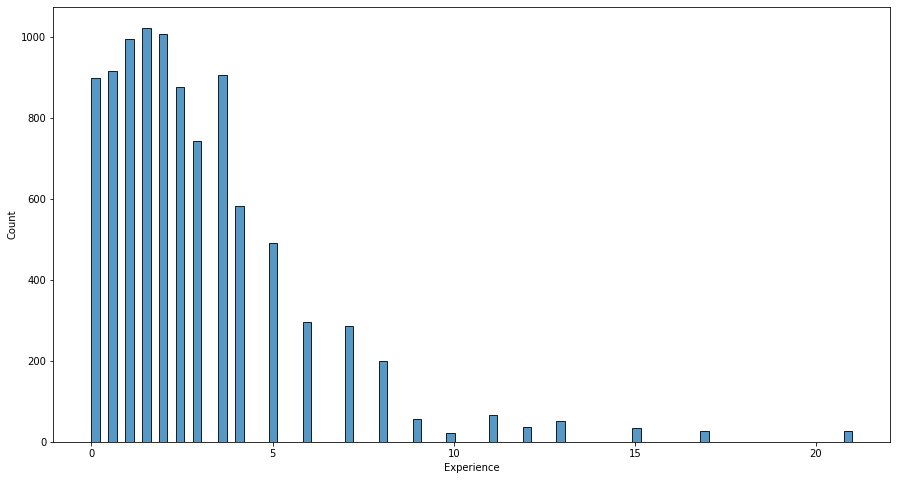

In [185]:
plt.figure(figsize=(15,8))
ax = sns.histplot(x="Experience", data=df, palette="Set3")

In [202]:
df['Exp_label'] = pd.cut(df['Experience'], bins=[0, 3, 7, 10, 23], include_lowest=True, labels=['Débutant', 'Confirmé', 'Avancé', 'Expert'])

## Question 6

In [187]:
top5_tech = (pd.Series(np.hstack(df['Technologies'].str.split('/')))
    .value_counts()
    .reset_index()
    .rename(columns={0: 'count'})
    .head(5))

La technologie la plus présente est Python, devant R et SQL.

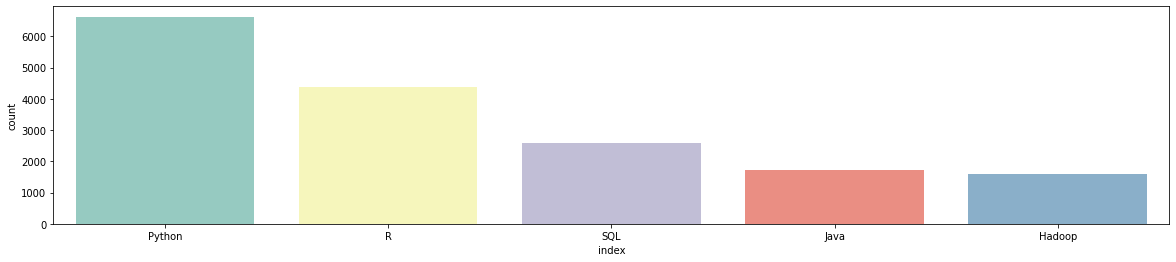

In [188]:
plt.figure(figsize=(20,4))
ax = sns.barplot(x='index', y="count", data=top5_tech, palette="Set3")

## Question 7

Je souhaite utiliser l'information des technologies utilisées. Pour cela, je crée une variable dummy pour chacune des 10 technologies les plus populaires dans la base de données. Si celle-ci est utilisée par un individu, alors la dummy prend la valeur 1.

In [278]:
top10_tech = (pd.Series(np.hstack(df['Technologies'].str.split('/'))).value_counts().head(10).index)

for tech in top10_tech:
    df[tech] = df['Technologies'].str.contains(tech,  regex=False)

Je transforme les variables catégorielles Métier et Diplôme en variable dummy.

In [281]:
df = (df
        .join(pd.get_dummies(df['Metier']))
        .join(pd.get_dummies(df['Diplome']))
        )

Kmeans joue sur les distances donc la standardisation des distance est importante : je l'applique pour chaque variable explicatives.

In [282]:
features = ['Experience', 'Data architecte', 'Data engineer', 'Data scientist', 'Lead data scientist', 'Bachelor', 'Master', 'No diploma', 'Phd'] + top10_tech.tolist()
df[features] = MinMaxScaler(feature_range=(0, 1)).fit_transform(df[features])

J'utilise la méthode du "coude" (Elbow method) pour choisir le k optimal ==> Je choisit k = 6 qui semble être assez coudé dans le graph ci-dessous.

In [283]:
list_inertia = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, max_iter=20).fit(df.dropna()[features])
    list_inertia.append(kmeans.inertia_)
res = pd.DataFrame({'k': range(1, 15), 'inertia': list_inertia})

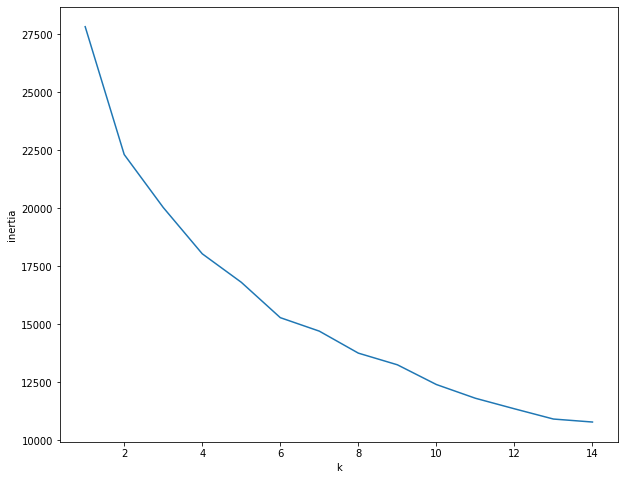

In [284]:
plt.figure(figsize=(10,8))
ax = sns.lineplot(x='k', y="inertia", data=res)

In [285]:
kmeans = KMeans(n_clusters=6, max_iter=20).fit(df.dropna()[features])

In [287]:
caract = pd.DataFrame(kmeans.cluster_centers_, columns=features).round(2)
caract.insert(0, 'cluster', range(1, 7))

In [288]:
caract

,cluster,Experience,Data architecte,Data engineer,Data scientist,Lead data scientist,Bachelor,Master,No diploma,Phd,Python,R,SQL,Java,Hadoop,Excel,C++,Spark,Linux,MongoDB
0,1,0.19,0.00,-0.00,-0.00,1.0,0.16,0.59,0.02,0.23,0.92,0.89,0.59,0.04,0.15,0.19,0.16,0.06,0.00,0.02
1,2,0.14,0.25,0.75,-0.00,0.0,0.17,0.54,0.19,0.11,-0.00,0.07,0.69,0.23,0.37,0.00,0.00,0.00,0.07,0.66
2,3,0.11,0.00,0.01,0.99,0.0,0.22,0.00,0.04,0.74,0.86,0.84,0.35,0.05,0.07,0.28,0.22,0.13,-0.00,0.02
3,4,0.10,0.00,-0.00,1.00,0.0,0.00,1.00,0.00,-0.00,0.84,0.86,0.35,0.06,0.06,0.32,0.23,0.14,0.00,0.02
4,5,0.14,1.00,-0.00,0.00,0.0,0.19,0.51,0.20,0.11,0.57,0.07,0.00,0.37,0.41,0.00,0.05,0.14,0.20,0.08
5,6,0.14,0.00,1.00,-0.00,0.0,0.14,0.54,0.19,0.13,0.87,0.12,0.00,0.37,0.03,0.00,0.15,0.41,0.55,0.04


## Question 8

Train, test and eval sets

In [290]:


df['set_'] = 'train'
df.loc[df.Metier.isna(), 'set_'] = 'test'
list_eval = random.choices(df.index[df['set_'] == 'train'], k=round(0.2*sum(df['set_'] == 'train')))
df.loc[list_eval, 'set_'] = 'eval'

df['set_'].value_counts()

train    7839
eval     1724
test       19
Name: set_, dtype: int64

In [291]:
features = ['Experience', 'Bachelor', 'Master', 'No diploma', 'Phd'] + top10_tech.tolist()

df = df[(df[features].isna().sum(1) == 0)]

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(df.loc[df['set_'] == 'train', features], df.loc[df['set_'] == 'train', 'Metier'])
df['pred'] = neigh.predict(df[features])

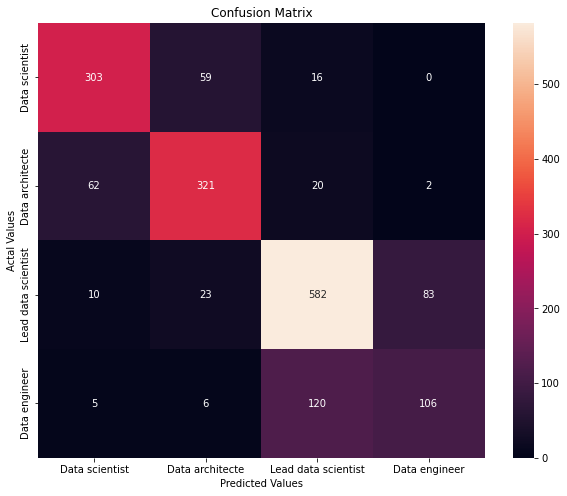

In [292]:
cm = confusion_matrix(df.loc[df['set_'] == 'eval', 'Metier'].astype('str'), df.loc[df['set_'] == 'eval', 'pred'].astype('str'))
cm_df = pd.DataFrame(cm, index = df.pred.unique(),  columns = df.pred.unique())

plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [293]:
np.trace(cm)/np.sum(cm)

0.7636786961583236